In [37]:
import sunpy 
import sunpy.map 
from sunpy.coordinates import SphericalScreen
import numpy as np 
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits 
import astropy.units as u
from astropy.visualization import ImageNormalize, AsinhStretch, LogStretch
from astropy.coordinates import SkyCoord
from PyThea.geometrical_models import gcs

##### LASCO jp2 are avaialble at [here](https://gs671-suske.ndc.nasa.gov/jp2/LASCO-C3/2025/09/13/white-light/2025_09_13__02_30_07_584__SOHO_LASCO_C3_white-light.jp2)
##### PUNCH CIM fits are avaialble at [here](https://umbra.nascom.nasa.gov/punch/3/CIM/2025/09/13/PUNCH_L3_CIM_20250913022429_v0g.fits)

In [3]:
lasco_map = sunpy.map.Map("../data/lasco/c3/2025_09_13__02_30_07_584__SOHO_LASCO_C3_white-light.jp2")

2025-10-06 16:19:49 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]
2025-10-06 16:19:49 - sunpy - WARNING: SunpyMetadataWarning: Missing metadata for observer: assuming Earth-based observer.
For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


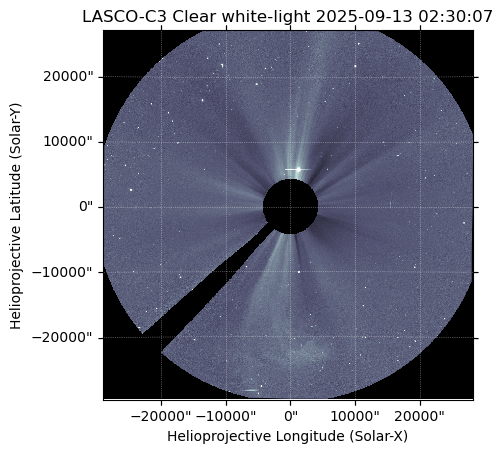

In [4]:
lasco_map.plot()

In [17]:
with fits.open("../data/punch/cim/PUNCH_L3_CIM_20250913022429_v0g.fits") as hdul:
    hdul.info()
    punch_cim_data = hdul[1].data.copy()
    punch_cim_header = hdul[1].header.copy()

Filename: ../data/punch/cim/PUNCH_L3_CIM_20250913022429_v0g.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  PRIMARY DATA ARRAY    1 CompImageHDU    131   (4096, 4096)   float32   
  2  FILE PROVENANCE    1 BinTableHDU     13   1R x 1C   [40A]   


In [28]:
punch_map.data.shape

(4096, 4096)

In [29]:
punch_map = sunpy.map.Map(punch_cim_data, punch_cim_header)
punch_map = punch_map.submap(
    bottom_left=(1023, 1023)*u.pixel,
    top_right=(3071, 3071)*u.pixel,
)

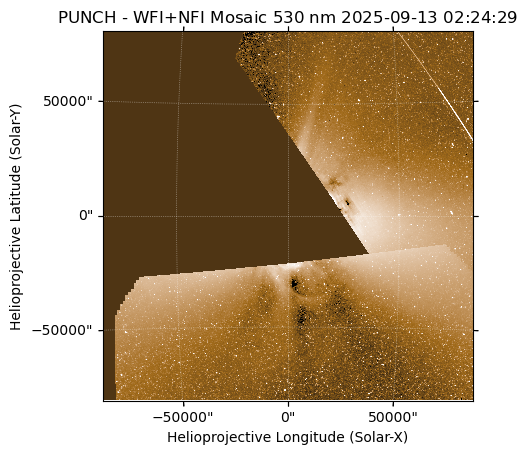

In [31]:
punch_map.plot(
    norm=ImageNormalize(
        vmin=np.nanpercentile(punch_cim_data, 0.1),
        vmax=np.nanpercentile(punch_cim_data, 99.9),
        stretch=LogStretch(),
    )
)

In [32]:
with SphericalScreen(lasco_map.observer_coordinate):
    lasco_map_reproj = lasco_map.reproject_to(punch_map.wcs)

2025-10-06 16:34:03 - reproject.common - INFO: Calling _reproject_full in non-dask mode
2025-10-06 16:34:10 - sunpy - INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


Text(0.5, 1.0, 'LASCO C3 and PUNCH CIM 2025-09-13T02:24:29.091')

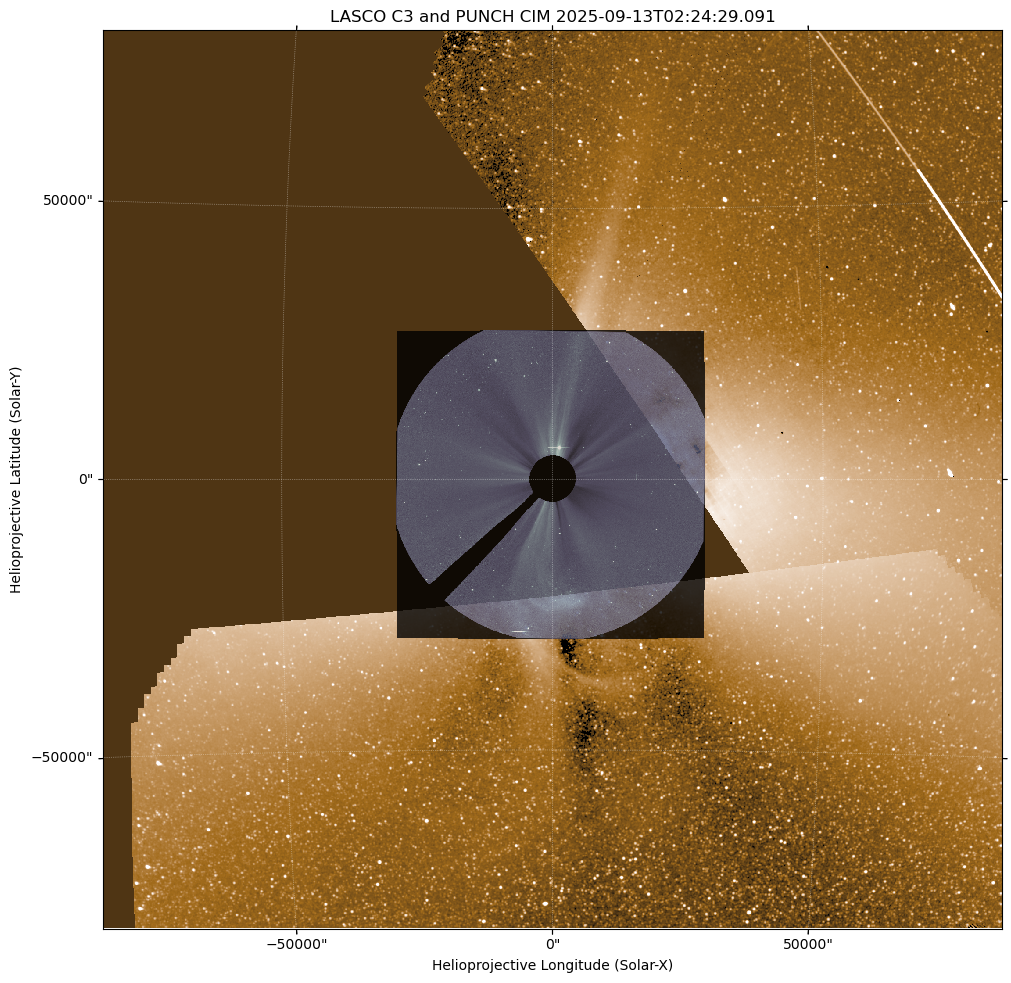

In [35]:
fig = plt.figure(figsize=(10,10), layout="constrained")

ax = fig.add_subplot(111, projection=punch_map.wcs)
punch_map.plot(axes=ax, norm=ImageNormalize(
        vmin=np.nanpercentile(punch_cim_data, 0.1),
        vmax=np.nanpercentile(punch_cim_data, 99.9),
        stretch=LogStretch(),
    ))

lasco_map_reproj.plot(axes=ax, alpha=0.8)

ax.set_title(f"LASCO C3 and PUNCH CIM {punch_map.date}")

Text(0.5, 1.0, 'LASCO C3 and PUNCH CIM with bad GCS fitting 2025-09-13T02:24:29.091')

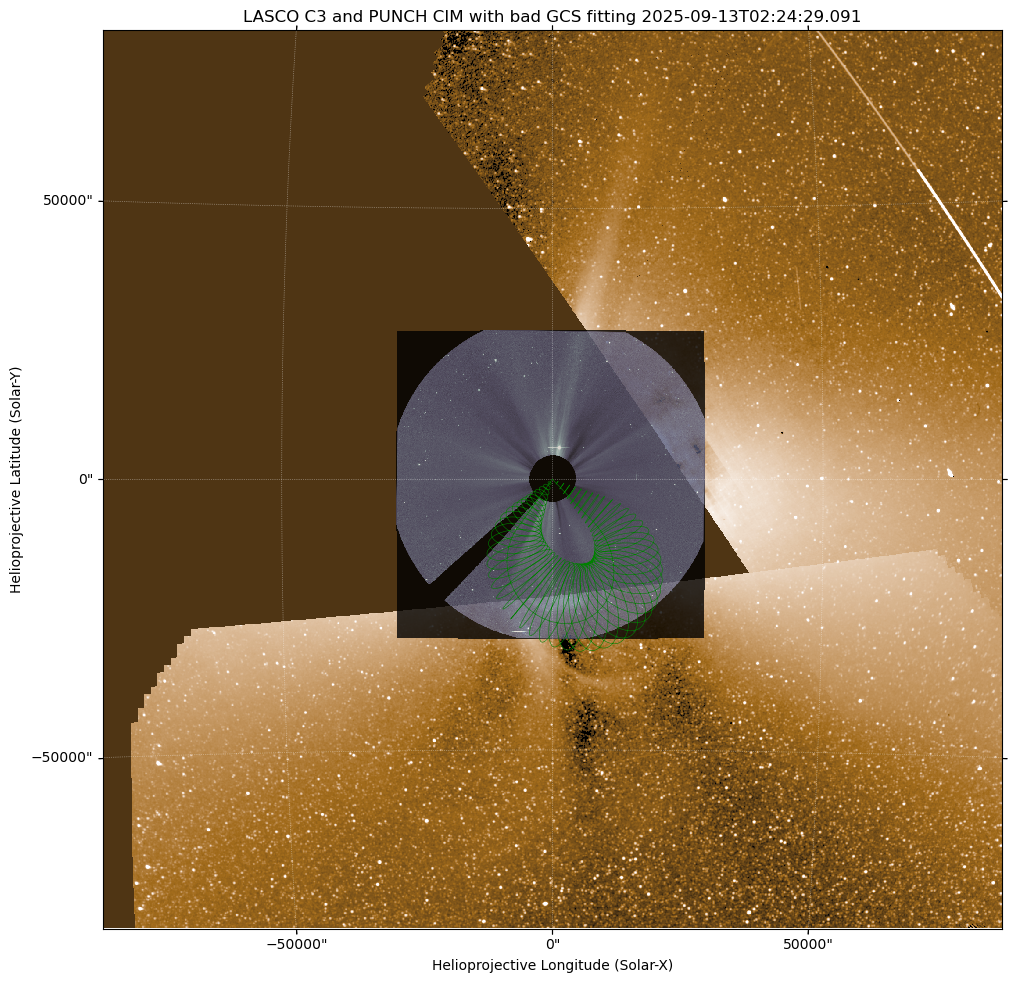

In [44]:
cme_center = SkyCoord(
    lon=25*u.degree,
    lat=-55*u.degree,
    radius=30*u.R_sun,
    obstime=punch_map.date, observer='earth',
    frame="heliographic_stonyhurst")

cme_gcs_model = gcs(
    cme_center,
    height=(30+5)*u.R_sun,
    alpha=45*u.deg,
    kappa=0.3,
    tilt=0*u.deg,
)



fig = plt.figure(figsize=(10,10), layout="constrained")

ax = fig.add_subplot(111, projection=punch_map.wcs)
punch_map.plot(axes=ax, norm=ImageNormalize(
        vmin=np.nanpercentile(punch_cim_data, 0.1),
        vmax=np.nanpercentile(punch_cim_data, 99.9),
        stretch=LogStretch(),
    ))

lasco_map_reproj.plot(axes=ax, alpha=0.8)

cme_gcs_model.plot(ax, mode="Full")

ax.set_title(f"LASCO C3 and PUNCH CIM with bad GCS fitting {punch_map.date}")